In [1]:
from bmipy import Bmi
from bmi_EnKF import BMIEnKF 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define system dynamics (F_func) and measurement function (H_func) => CFE
F_func = lambda x: np.array([x[0] + 0.5 , x[1]+3])  
H_func = lambda x: np.array([ x[0] + np.sin(x[1]) + x[0] * x[1] *0.02])

In [3]:
np.random.seed(0)

In [4]:
# Synthetic Example
n = 2  # dimension of states
m = 1  # dimension of measurements
N = 10000  # number of ensembles

R = np.eye(m) * 0.01 # measurement noise
Q = np.eye(n) * 1  # process noise

# Initial state and covariance
x0 = np.zeros(n)
P = np.eye(n) * 0.01

# time window
num_time_steps = 30

# Create synthetic "ground truth" data and synthetic measurements
x_true = np.zeros((n, num_time_steps))
y = np.zeros((m, num_time_steps))
x_true[:, 0] = np.random.multivariate_normal(x0, P)
y[:, 0] = H_func(x_true[:, 0]) + np.random.multivariate_normal(np.zeros(m), R)

for t in range(1, num_time_steps):
    x_true[:, t] = F_func(x_true[:, t-1]) + np.random.multivariate_normal(np.zeros(n), Q)
    y[:, t] = H_func(x_true[:, t]) + np.random.multivariate_normal(np.zeros(m), R)

# test nan value
y[:,14] = None

##----------------------------BMI-EnKF--------------------------------------------------#

bmi_enkf = BMIEnKF(n, m, R, Q, N, x0, P, num_time_steps)

bmi_enkf.initialize()
Q_obs = []

for t in range(num_time_steps):
    #CFE-pert
    F_results = [F_func(bmi_enkf.enkf.ensembles[:, i]) for i in range(N)] # this should be CFE-pert states
    H_results = [H_func(bmi_enkf.enkf.ensembles[:, i]) for i in range(N)] # this should be CFE-pert outputs
    #DA
    bmi_enkf.update(y[:, t], F_results, H_results) # run EnKF y[:, t] is from USGS
    x_estimated = bmi_enkf.get_value("state_estimates")
    #CFE-analysis
    Q_final = H_func(x_estimated[:, t]) # CFE-analysis based on assimilated states
    Q_obs.append(Q_final)
bmi_enkf.finalize()

# Get state estimates and covariance
x_estimated = bmi_enkf.get_value("state_estimates")
covariance_matrices = bmi_enkf.get_value("covariance_matrices")

In [5]:
# uncertaitny boudns
standard_deviations = np.zeros((n, num_time_steps))
for t in range(num_time_steps):
    standard_deviations[:, t] = np.sqrt(np.diag(covariance_matrices[:, :, t]))

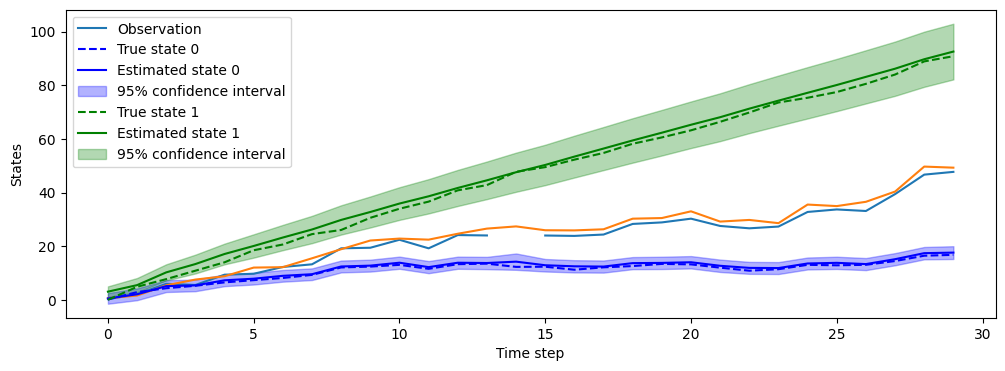

In [6]:
colors = ['blue', 'green', 'red', 'purple'] 

plt.figure(figsize = (12, 4))
plt.plot(y.T, label="Observation")
plt.plot(H_func(x_estimated).T)
for i in range(n):
    plt.plot(x_true[i, :], color=colors[i], linestyle = '--' , label=f"True state {i}")
    plt.plot(x_estimated[i, :], color=colors[i], label=f"Estimated state {i}")
    plt.fill_between(
        np.arange(num_time_steps),
        x_estimated[i, :] - 1.96 * standard_deviations[i, :],
        x_estimated[i, :] + 1.96 * standard_deviations[i, :],
        color=colors[i], alpha=0.3,
        label = f"95% confidence interval"
    )
plt.xlabel('Time step')
plt.ylabel('States')
plt.legend()
plt.show()

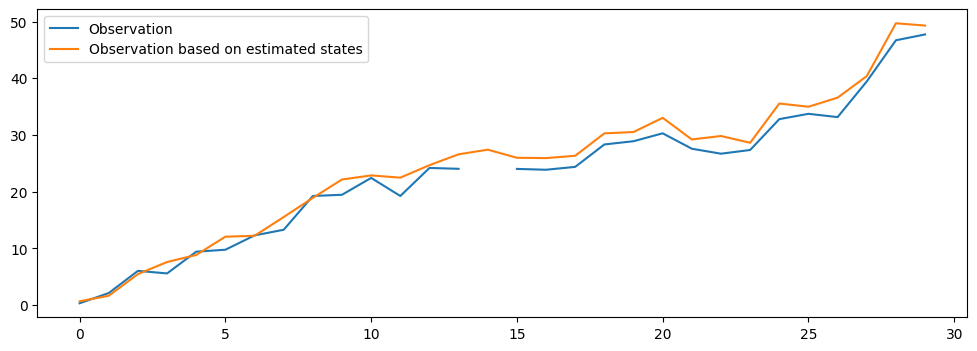

In [7]:
plt.figure(figsize = (12, 4))
plt.plot(y.T, label="Observation")
plt.plot(Q_obs, label="Observation based on estimated states")
plt.legend()